## 3. 회귀분석 연관문제

### 3.1. 변수선택

- ISLP의 Hitters 데이터셋을 이용

- 최량 부분집합, 전진선택, 후진소거, 단계적 선택법에 따라 최적 부분집합으로 선택한 변수의 조합이 달라지는 점 확인

- 선택의 기준이 되는 평가 메트릭이 달라졌을 때에 최적 부분집합이 달라지는 점 확인

- lesson3.py 파일에 함수를 구현한 후 호출하는 방식으로 전체 코드를 구현하면 어떻게 달라지는지 확인

- 최량 부분집합 선택 방법과 나머지 방법들을 실행했을 때의 시간 차이도 확인

In [57]:
# 준비 작업
## 패키지 로딩
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 모듈 리로딩을 위한 importlib 코드
import importlib
import lesson3
importlib.reload(lesson3)

# lesson3.py 파일로 생성한 함수 불러오기
from lesson3 import (
    setup_korean_font,
    best_subset,
    forward_selection, 
    backward_elimination,
    hybrid_stepwise,
    calculate_metrics,
    compute_coefficient_paths,
    format_selection_results,
    compare_methods_results,
    find_optimal_models_by_criteria,
    plot_ice_curves,
    plot_categorical_ice,
    analyze_ice_heterogeneity
)

## 한글 폰트 설정
setup_korean_font()

## 랜덤 시드 고정
np.random.seed(42)

In [58]:
## 데이터셋 로딩
hitters = load_data('Hitters')
hitters.dropna(inplace=True)

In [59]:
# 데이터 전처리 및 탐색
## 데이터 전처리
numeric_cols = hitters.select_dtypes(include=[np.number]).columns.tolist()
predictor_pool = [c for c in numeric_cols if c != 'Salary']
response = 'Salary'

print(f"사용 변수 개수: {len(predictor_pool)} -> {predictor_pool}")
print(f"반응변수: {response}")

data = hitters[[response] + predictor_pool].reset_index(drop=True)

print('데이터 형태:', data.shape)
print(data.head())

## 변수선택에 필요한 형태로 데이터 분리
X = data[predictor_pool]
y = data[response]
n, p_full = X.shape

사용 변수 개수: 16 -> ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
반응변수: Salary
데이터 형태: (263, 17)
   Salary  AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
0   475.0    315    81      7    24   38     39     14    3449    835      69   
1   480.0    479   130     18    66   72     76      3    1624    457      63   
2   500.0    496   141     20    65   78     37     11    5628   1575     225   
3    91.5    321    87     10    39   42     30      2     396    101      12   
4   750.0    594   169      4    74   51     35     11    4408   1133      19   

   CRuns  CRBI  CWalks  PutOuts  Assists  Errors  
0    321   414     375      632       43      10  
1    224   266     263      880       82      14  
2    828   838     354      200       11       3  
3     48    46      33      805       40       4  
4    501   336     194      282      421      25  


#### 3.1.1 최량 부분집합 선택 (Best Subset Selection)

In [60]:
# 데이터 준비
X = data[predictor_pool]
y = data[response]
n, p_full = X.shape

## AIC 기준으로 최량 부분집합 선택
best_models = best_subset(X, y, cri = 'aic')

## 새로운 함수를 사용한 결과 정리
best_subset_df = format_selection_results(X, y, best_models, '최량 부분집합', 'aic', n)

print("\n최량 부분집합 선택 결과 (AIC 기준):")
display(best_subset_df.round(4))


최량 부분집합 선택 결과 (AIC 기준):


,k,variables,AIC,BIC,CP,ADJ_R2,RSS
0,1,CRBI,3862.1393,3869.2836,94.5992,0.3189,3.617968e+07
1,2,"Hits, CRBI",3820.4873,3831.2038,42.5217,0.4208,3.064656e+07
2,3,"Hits, CRBI, PutOuts",3810.2144,3824.5031,30.8657,0.4451,2.924930e+07
3,4,"AtBat, Hits, CRBI, PutOuts",3802.9730,3820.8337,22.9952,0.4622,2.823936e+07
4,5,"AtBat, Hits, Walks, CRBI, PutOuts",3794.8244,3816.2573,14.5480,0.4805,2.717042e+07
5,6,"AtBat, Hits, Walks, CRuns, CWalks, PutOuts",3793.2505,3818.2556,12.9639,0.4855,2.680370e+07
6,7,"AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Put...",3787.5879,3816.1651,7.4416,0.4983,2.603404e+07
7,8,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3785.7489,3817.8983,5.7544,0.5037,2.565678e+07
8,9,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
9,10,"AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI,...",3785.4875,3824.7812,5.7242,0.5078,2.524441e+07


#### 3.1.2. 전진 선택 (Forward Selection)

In [61]:
## BIC 기준으로 전진선택법 실행
forward_models = forward_selection(X, y, cri = 'aic')

## 새로운 함수를 사용한 결과 정리
forward_df = format_selection_results(X, y, forward_models, '전진선택법', 'aic', n)

print("\n전진선택법 결과 (AIC 기준):")
display(forward_df.round(4))


전진선택법 결과 (AIC 기준):


,k,variables,AIC,BIC,CP,ADJ_R2,RSS
0,1,CRBI,3862.1393,3869.2836,94.5992,0.3189,3.617968e+07
1,2,"CRBI, Hits",3820.4873,3831.2038,42.5217,0.4208,3.064656e+07
2,3,"CRBI, Hits, PutOuts",3810.2144,3824.5031,30.8657,0.4451,2.924930e+07
3,4,"CRBI, Hits, PutOuts, AtBat",3802.9730,3820.8337,22.9952,0.4622,2.823936e+07
4,5,"CRBI, Hits, PutOuts, AtBat, Walks",3794.8244,3816.2573,14.5480,0.4805,2.717042e+07
5,6,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks",3795.0936,3820.0986,14.8061,0.4819,2.699220e+07
6,7,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRuns",3788.6810,3817.2582,8.5013,0.4962,2.614246e+07
7,8,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3785.7489,3817.8983,5.7544,0.5037,2.565678e+07
8,9,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
9,10,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3785.4875,3824.7812,5.7242,0.5078,2.524441e+07


#### 3.1.3. 후진 선택 (Backward Elimination)

In [62]:
## AIC 기준으로 후진소거법 실행
backward_models = backward_elimination(X, y, cri = 'aic')

## 새로운 함수를 사용한 결과 정리
backward_df = format_selection_results(X, y, backward_models, '후진소거법', 'aic', n)

print("\n후진소거법 결과 (AIC 기준):")
display(backward_df.round(4))


후진소거법 결과 (AIC 기준):


,k,variables,AIC,BIC,CP,ADJ_R2,RSS
0,16,"AtBat, Hits, HmRun, Runs, RBI, Walks, Years, C...",3796.7144,3857.4410,17.0000,0.4972,2.517031e+07
1,15,"AtBat, Hits, HmRun, Runs, Walks, Years, CAtBat...",3794.7144,3851.8689,15.0001,0.4993,2.517032e+07
2,14,"AtBat, Hits, HmRun, Runs, Walks, Years, CAtBat...",3792.7263,3846.3086,13.0112,0.5013,2.517145e+07
3,13,"AtBat, Hits, HmRun, Runs, Walks, CAtBat, CHmRu...",3790.7831,3840.7933,11.0643,0.5032,2.517689e+07
4,12,"AtBat, Hits, HmRun, Runs, Walks, CAtBat, CRuns...",3788.8907,3835.3287,9.1650,0.5049,2.518719e+07
5,11,"AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI,...",3787.1378,3830.0036,7.3964,0.5064,2.521087e+07
6,10,"AtBat, Hits, Runs, Walks, CAtBat, CRuns, CRBI,...",3785.4875,3824.7812,5.7242,0.5078,2.524441e+07
7,9,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
8,8,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3785.7489,3817.8983,5.7544,0.5037,2.565678e+07
9,7,"AtBat, Hits, Walks, CRuns, CRBI, CWalks, PutOuts",3788.6810,3817.2582,8.5013,0.4962,2.614246e+07


#### 3.1.4. 단계적 선택 (Stepwise Selection)

In [63]:
## AIC 기준으로 하이브리드 단계적 선택법 실행
hybrid_models = hybrid_stepwise(X, y, cri = 'aic')

## 새로운 함수를 사용한 결과 정리
hybrid_df = format_selection_results(X, y, hybrid_models, '하이브리드 단계적 선택법', 'aic', n)

print("\n하이브리드 단계적 선택법 결과 (AIC 기준):")
display(hybrid_df.round(4))


하이브리드 단계적 선택법 결과 (AIC 기준):


,k,variables,AIC,BIC,CP,ADJ_R2,RSS
0,1,CRBI,3862.1393,3869.2836,94.5992,0.3189,3.617968e+07
1,2,"CRBI, Hits",3820.4873,3831.2038,42.5217,0.4208,3.064656e+07
2,3,"CRBI, Hits, PutOuts",3810.2144,3824.5031,30.8657,0.4451,2.924930e+07
3,4,"CRBI, Hits, PutOuts, AtBat",3802.9730,3820.8337,22.9952,0.4622,2.823936e+07
4,5,"CRBI, Hits, PutOuts, AtBat, Walks",3794.8244,3816.2573,14.5480,0.4805,2.717042e+07
5,6,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks",3795.0936,3820.0986,14.8061,0.4819,2.699220e+07
6,7,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRuns",3788.6810,3817.2582,8.5013,0.4962,2.614246e+07
7,8,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3785.7489,3817.8983,5.7544,0.5037,2.565678e+07
8,9,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
9,10,"CRBI, Hits, PutOuts, AtBat, Walks, CWalks, CRu...",3785.4875,3824.7812,5.7242,0.5078,2.524441e+07


#### 3.1.5. 선택 메트릭에 따른 비교

In [64]:
## 선택 기준을 다르게 해서 최량 부분집합 선택 실행
criteria_models = {}
for cri in ['aic', 'bic', 'cp', 'adj_r2']:
    print(f"\n{cri.upper()} 기준으로 최량 부분집합 선택...")
    models = best_subset(X, y, cri=cri)
    criteria_models[cri] = models

## 각 기준별 최적 모델
optimal_comparison = find_optimal_models_by_criteria(X, y, criteria_models['aic'], n)
print("각 기준별 최적 모델:")
display(optimal_comparison.round(4))

## 각 기준별 최적 k 비교
optimal_ks = optimal_comparison['Optimal_k'].tolist()
unique_ks = set(optimal_ks)

print(f"\n=== 각 기준별 최적 모델 크기 비교 ===")
for _, row in optimal_comparison.iterrows():
    print(f"{row['Criterion']:6} 최적 k: {row['Optimal_k']}")


AIC 기준으로 최량 부분집합 선택...

BIC 기준으로 최량 부분집합 선택...

CP 기준으로 최량 부분집합 선택...

ADJ_R2 기준으로 최량 부분집합 선택...
각 기준별 최적 모델:


,Criterion,Optimal_k,Variables,AIC,BIC,CP,ADJ_R2,RSS
0,AIC,9,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
1,BIC,7,"AtBat, Hits, Walks, CHmRun, CRuns, CWalks, Put...",3787.5879,3816.1651,7.4416,0.4983,2.603404e+07
2,CP,9,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
3,ADJ_R2,9,"AtBat, Hits, Walks, CAtBat, CRuns, CRBI, CWalk...",3784.0543,3819.7758,4.2565,0.5086,2.529887e+07
4,RSS,16,"AtBat, Hits, HmRun, Runs, RBI, Walks, Years, C...",3796.7144,3857.4410,17.0000,0.4972,2.517031e+07



=== 각 기준별 최적 모델 크기 비교 ===
AIC    최적 k: 9
BIC    최적 k: 7
CP     최적 k: 9
ADJ_R2 최적 k: 9
RSS    최적 k: 16


## 3.2. 정규화 선형회귀

- ISLP의 Hitters 데이터셋 이용

- 정규화 선형회귀를 구현하기 위해서는 반드시 변수 표준화를 거쳐야 함

- 릿지, 라쏘 모형을 적합했을 때에 여러 alpha(λ) 값에 따라 계수 경로가 어떻게 달라지는지 확인

- 데이터를 분할하여 최적 alpha를 선택하는 방법 확인

### 3.2.1. 릿지, 라쏘회귀모형 적합

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


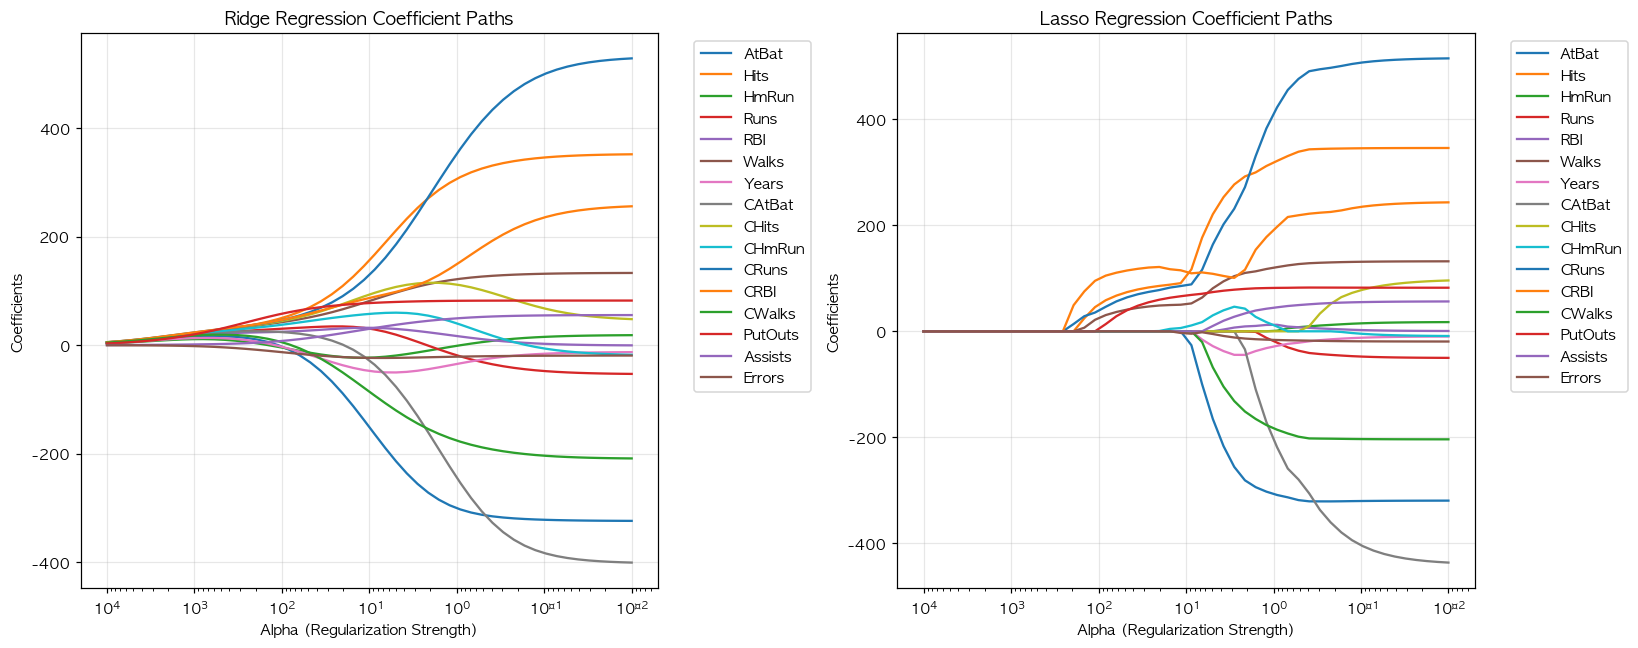

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# alpha 경로 설정
alphas = np.logspace(4, -2, 50)  # 10^4 부터 10^-2 까지

# 릿지, 라쏘모형 적합 및 회귀계수 계산
ridge_coefs, lasso_coefs = compute_coefficient_paths(X_scaled, y, alphas)

# 계수 경로 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Ridge 경로
for j in range(ridge_coefs.shape[1]):
    ax1.plot(alphas, ridge_coefs[:, j], label=predictor_pool[j])
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.set_xlabel('Alpha (Regularization Strength)')
ax1.set_ylabel('Coefficients')
ax1.set_title('Ridge Regression Coefficient Paths')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Lasso 경로
for j in range(lasso_coefs.shape[1]):
    ax2.plot(alphas, lasso_coefs[:, j], label=predictor_pool[j])
ax2.set_xscale('log')
ax2.invert_xaxis()
ax2.set_xlabel('Alpha (Regularization Strength)')
ax2.set_ylabel('Coefficients')
ax2.set_title('Lasso Regression Coefficient Paths')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 3.2.2. 엘라스틱넷

In [66]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

# l1_ratio는 릿지와 라쏘 벌점항 혼합비율을 결정하는 초모수
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# ElasticNetCV로 최적 (alpha, l1_ratio) 선택
elastic_cv = ElasticNetCV(
    l1_ratio=l1_ratios,
    alphas=alphas,  # 이전에 정의된 alpha 그리드 사용
    cv=10,
    max_iter=1000,
    random_state=42
)

elastic_cv.fit(X_scaled, y)

print(f"Elastic Net 최적 alpha: {elastic_cv.alpha_:.4f}")
print(f"Elastic Net 최적 l1_ratio: {elastic_cv.l1_ratio_:.2f}")

elastic_coef = elastic_cv.coef_

Elastic Net 최적 alpha: 0.0720
Elastic Net 최적 l1_ratio: 0.90


### 3.2.3. 세 가지 모형 비교

초모수와 회귀계수 비교

In [67]:
## CV를 통해 최적 alpha 선택
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring='neg_mean_squared_error')
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=1000, random_state=42)

ridge_cv.fit(X_scaled, y)
lasso_cv.fit(X_scaled, y)

print(f"Ridge 최적 alpha: {ridge_cv.alpha_:.4f}")
print(f"Lasso 최적 alpha: {lasso_cv.alpha_:.4f}")
print(f"Elastic Net 최적 alpha: {elastic_cv.alpha_:.4f}")

## 최적 모델의 계수 비교
ridge_coef = ridge_cv.coef_
lasso_coef = lasso_cv.coef_

## 3가지 모델 비교
comparison_df = pd.DataFrame({
    'Variable': predictor_pool,
    'Ridge': ridge_coef,
    'Lasso': lasso_coef,
    'Elastic_Net': elastic_coef,
    'Ridge_Zero': ridge_coef == 0,
    'Lasso_Zero': lasso_coef == 0,
    'Elastic_Zero': elastic_coef == 0
})

print("\n=== Ridge vs Lasso vs Elastic Net 회귀계수 비교 ===")
display(comparison_df.round(4))

Ridge 최적 alpha: 1.5999
Lasso 최적 alpha: 0.9103
Elastic Net 최적 alpha: 0.0720

=== Ridge vs Lasso vs Elastic Net 회귀계수 비교 ===


,Variable,Ridge,Lasso,Elastic_Net,Ridge_Zero,Lasso_Zero,Elastic_Zero
0,AtBat,-284.6824,-308.7448,-275.7820,False,False,False
1,Hits,286.1644,321.3413,275.7957,False,False,False
2,HmRun,-6.6040,1.1537,-8.5410,False,False,False
3,Runs,-7.7312,-21.4102,-2.5226,False,False,False
4,RBI,21.3007,12.2912,22.4837,False,False,False
5,Walks,116.4554,121.0086,113.5571,False,False,False
6,Years,-40.7306,-27.4382,-42.9732,False,False,False
7,CAtBat,-192.0260,-218.6723,-167.1482,False,False,False
8,CHits,114.9460,0.0000,111.9953,False,True,False
9,CHmRun,50.0656,8.8879,52.6872,False,False,False


변수 제거효과 비교

In [68]:
print(f"Ridge 제거 변수: {(ridge_coef == 0).sum()}/{len(predictor_pool)}")
print(f"Lasso 제거 변수: {(lasso_coef == 0).sum()}/{len(predictor_pool)}")
print(f"Elastic Net 제거 변수: {(elastic_coef == 0).sum()}/{len(predictor_pool)}")

# 제거된 변수들 표시
if (lasso_coef == 0).sum() > 0:
    lasso_zero_vars = comparison_df[comparison_df['Lasso_Zero']]['Variable'].tolist()
    print(f"Lasso 제거 변수: {', '.join(lasso_zero_vars)}")

if (elastic_coef == 0).sum() > 0:
    elastic_zero_vars = comparison_df[comparison_df['Elastic_Zero']]['Variable'].tolist()
    print(f"Elastic Net 제거 변수: {', '.join(elastic_zero_vars)}")

Ridge 제거 변수: 0/16
Lasso 제거 변수: 1/16
Elastic Net 제거 변수: 0/16
Lasso 제거 변수: CHits


MSE 비교

In [69]:
ridge_scores = cross_val_score(ridge_cv, X_scaled, y, cv=10, scoring='neg_mean_squared_error')
lasso_scores = cross_val_score(lasso_cv, X_scaled, y, cv=10, scoring='neg_mean_squared_error')
elastic_scores = cross_val_score(elastic_cv, X_scaled, y, cv=10, scoring='neg_mean_squared_error')

print(f"\n=== 성능 비교 (10-fold CV MSE) ===")
print(f"Ridge:      {-ridge_scores.mean():.2f} (±{ridge_scores.std():.2f})")
print(f"Lasso:      {-lasso_scores.mean():.2f} (±{lasso_scores.std():.2f})")
print(f"Elastic Net: {-elastic_scores.mean():.2f} (±{elastic_scores.std():.2f})")


=== 성능 비교 (10-fold CV MSE) ===
Ridge:      124500.13 (±69753.88)
Lasso:      128822.68 (±68671.52)
Elastic Net: 124671.44 (±70224.74)


시각화

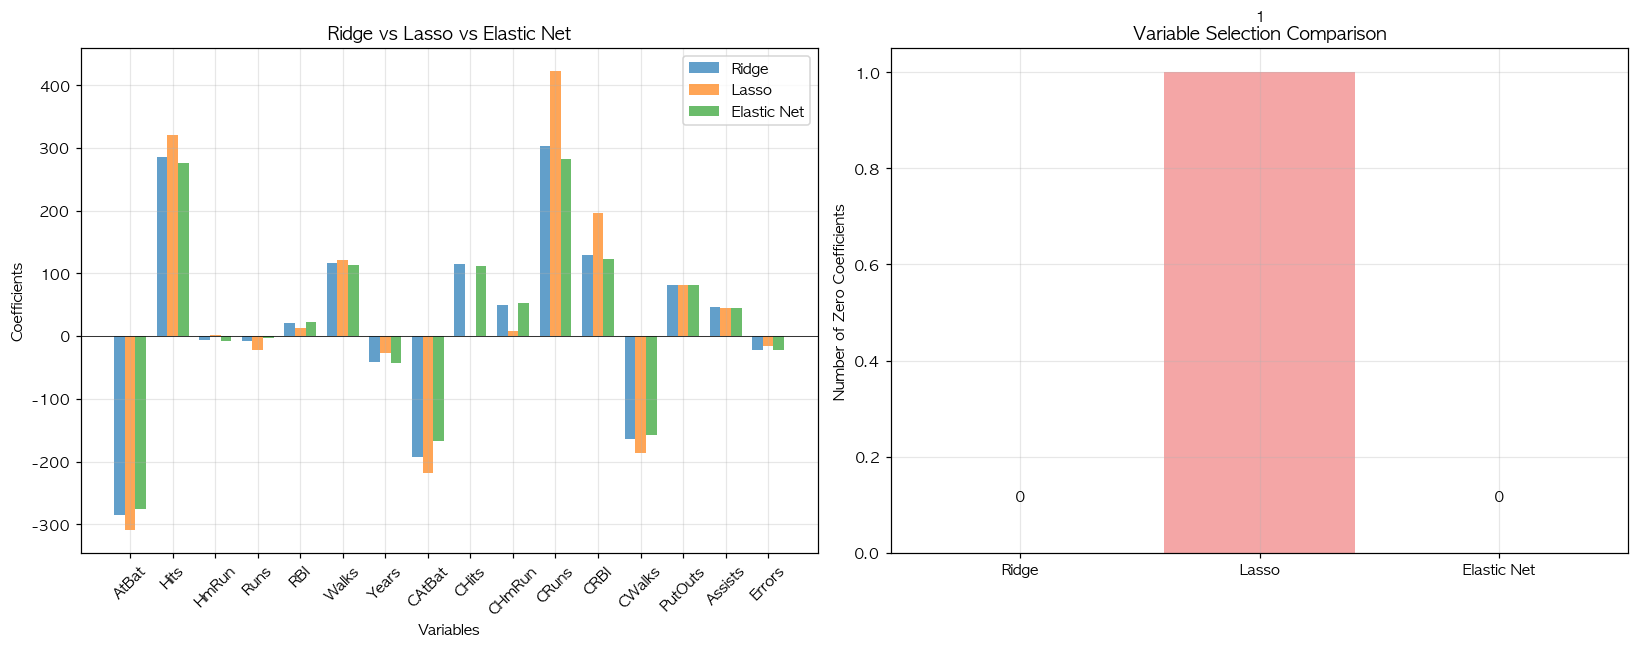

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 회귀계수
x_pos = np.arange(len(predictor_pool))
width = 0.25

axes[0].bar(x_pos - width, ridge_coef, width, label='Ridge', alpha=0.7)
axes[0].bar(x_pos, lasso_coef, width, label='Lasso', alpha=0.7)
axes[0].bar(x_pos + width, elastic_coef, width, label='Elastic Net', alpha=0.7)
axes[0].set_xlabel('Variables')
axes[0].set_ylabel('Coefficients')
axes[0].set_title('Ridge vs Lasso vs Elastic Net')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(predictor_pool, rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 제거된 변수의 수
methods = ['Ridge', 'Lasso', 'Elastic Net']
zero_counts = [
    (ridge_coef == 0).sum(),
    (lasso_coef == 0).sum(),
    (elastic_coef == 0).sum()
]

colors = ['skyblue', 'lightcoral', 'lightgreen']
axes[1].bar(methods, zero_counts, color=colors, alpha=0.7)
axes[1].set_ylabel('Number of Zero Coefficients')
axes[1].set_title('Variable Selection Comparison')
axes[1].grid(True, alpha=0.3)

# 각 막대 위에 숫자 표시
for i, count in enumerate(zero_counts):
    axes[1].text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 3.3. 일반화 가법 모형 (GAM)

- ISLP의 wage 데이터셋 이용

- age, year, education을 이용하여 wage의 변화를 예측하는 GAM 적합

- 스플라인을 이용하여 평활함수 추정

- 선형회귀모형과 GAM을 비교

### 3.3.1. 선형모형과 비교

In [71]:
# 분석 준비작업
## 패키지 로딩
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [72]:
# 데이터 로딩 및 전처리
## 데이터 로딩
wage_data = load_data('Wage')
print(f"Wage 데이터 로드 성공: {wage_data.shape}")

## 교육 수준을 숫자로 매핑
education_map = {
    '1. < HS Grad': 1,
    '2. HS Grad': 2, 
    '3. Some College': 3,
    '4. College Grad': 4,
    '5. Advanced Degree': 5
}
wage_data['education_num'] = wage_data['education'].map(education_map).astype(int)

## 결측치 제거
wage_clean = wage_data[['wage', 'age', 'year', 'education_num']].dropna()


# 변수 요약정보
print(f"삭제한 데이터: {wage_clean.shape}")
print("\n변수 정보:")
print(f"- wage: {wage_clean['wage'].min():.1f} ~ {wage_clean['wage'].max():.1f}")
print(f"- age: {wage_clean['age'].min()} ~ {wage_clean['age'].max()}")
print(f"- year: {wage_clean['year'].min()} ~ {wage_clean['year'].max()}")
print(f"- education_num 분포:")
print(wage_clean['education_num'].value_counts().sort_index())

Wage 데이터 로드 성공: (3000, 11)
삭제한 데이터: (3000, 4)

변수 정보:
- wage: 20.1 ~ 318.3
- age: 18 ~ 80
- year: 2003 ~ 2009
- education_num 분포:
education_num
1    268
2    971
3    650
4    685
5    426
Name: count, dtype: int64


In [73]:
# 모형 적합
## 선형회귀모형
linear_formula = 'wage ~ age + year + C(education_num)'
linear_model = smf.ols(linear_formula, data=wage_clean).fit()

print(f"선형 모형 R²: {linear_model.rsquared:.4f}")
print(f"선형 모형 AIC: {linear_model.aic:.2f}")

선형 모형 R²: 0.2619
선형 모형 AIC: 30002.62


In [74]:
## GAM 적합
from sklearn.preprocessing import SplineTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 전처리기 설정
preprocessor = ColumnTransformer([
    ('age_spline', SplineTransformer(n_knots=4, degree=3), ['age']),
    ('year_spline', SplineTransformer(n_knots=4, degree=3), ['year']),
    ('education', OneHotEncoder(drop='first'), ['education_num'])
])

# GAM 파이프라인
gam_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

## 설명, 반응변수 분리
X = wage_clean[['age', 'year', 'education_num']]
y = wage_clean['wage']

## 적합
gam_pipeline.fit(X, y)
gam_score = gam_pipeline.score(X, y)

print(f"GAM 모형 R²: {gam_score:.4f}")

GAM 모형 R²: 0.2920


### 3.3.2. PDP

부분의존성 플롯(Partial Dependent Plot)이란 특정 설명변수와 반응변수의 진짜 관계를 확인하기 위해 다른 설명변수의 효과를 고정한 상태에서 두 변수의 관계를 보여주는 도표. 함수 도출을 위해 설명변수 간의 독립을 가정하기 때문에 상관성이 큰 설명변수의 존재로 인한 효과를 축소해서 왜곡한다는 단점이 있음

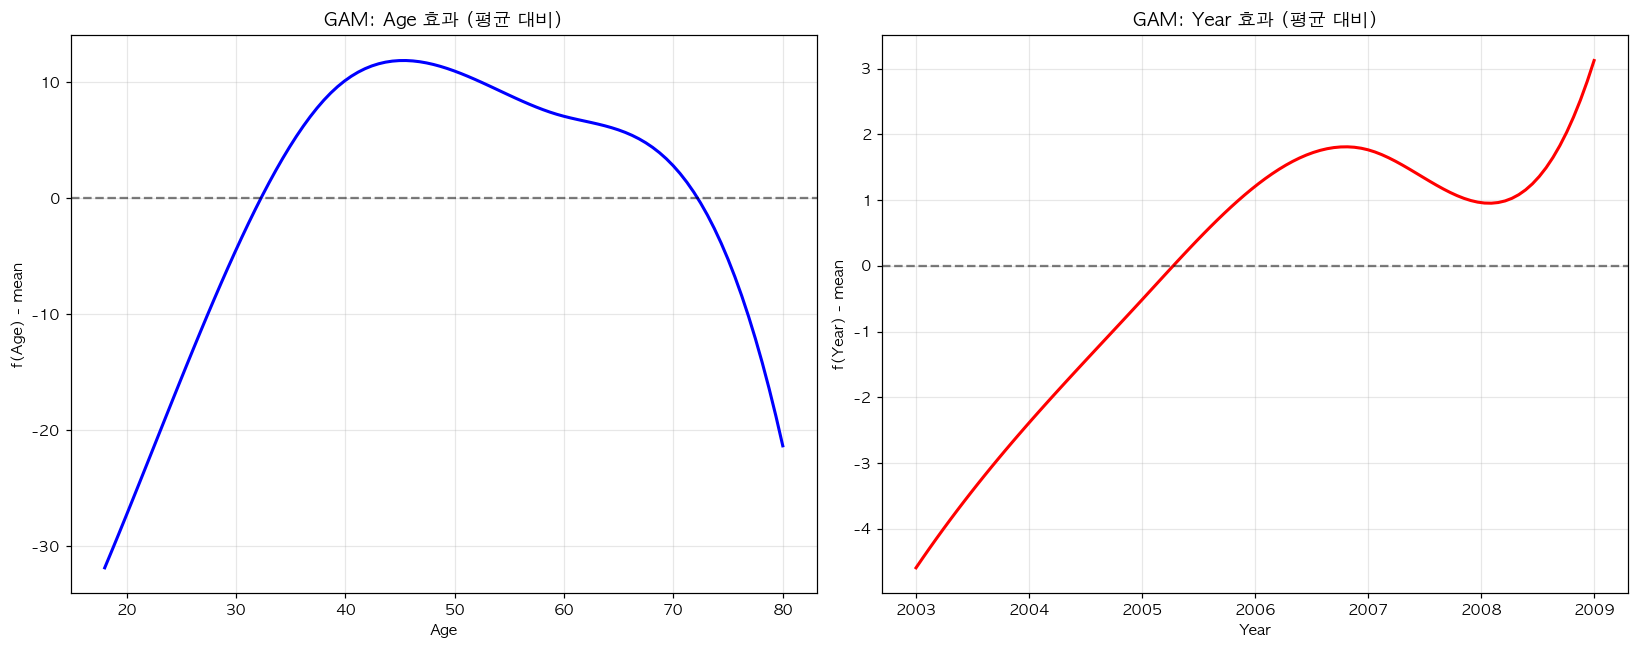

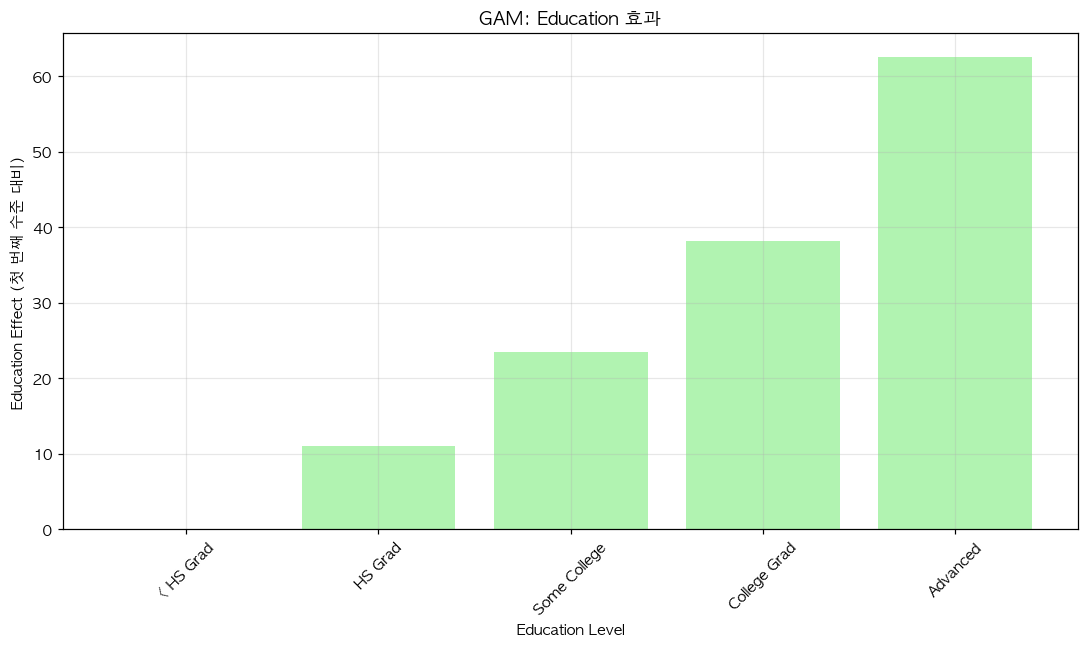

In [75]:
# 부분의존성 플롯(pd 플롯)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Age 효과 계산
age_range = np.linspace(wage_clean['age'].min(), wage_clean['age'].max(), 100)
median_year = wage_clean['year'].median()
mode_edu = wage_clean['education_num'].mode()[0]  # 최빈값 사용

# Age
X_age = pd.DataFrame({
    'age': age_range,
    'year': [median_year] * 100,
    'education_num': [mode_edu] * 100
})

age_predictions = gam_pipeline.predict(X_age)

# 상대 효과 = 평균으로부터의 편차
age_effect = age_predictions - age_predictions.mean()

axes[0].plot(age_range, age_effect, 'b-', linewidth=2)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('f(Age) - mean')
axes[0].set_title('GAM: Age 효과 (평균 대비)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Year
year_range = np.linspace(wage_clean['year'].min(), wage_clean['year'].max(), 100)
median_age = wage_clean['age'].median()

X_year = pd.DataFrame({
    'age': [median_age] * 100,
    'year': year_range,
    'education_num': [mode_edu] * 100
})

year_predictions = gam_pipeline.predict(X_year)
year_effect = year_predictions - year_predictions.mean()

axes[1].plot(year_range, year_effect, 'r-', linewidth=2)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('f(Year) - mean')
axes[1].set_title('GAM: Year 효과 (평균 대비)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 교육 수준
education_levels = sorted(wage_clean['education_num'].unique())
education_effects = []

for edu_level in education_levels:
    X_edu = pd.DataFrame({
        'age': [median_age],
        'year': [median_year],
        'education_num': [edu_level]
    })
    pred = gam_pipeline.predict(X_edu)[0]
    education_effects.append(pred)

# 첫 번째 교육 수준을 기준으로 상대적 효과 계산
base_effect = education_effects[0]
relative_effects = [effect - base_effect for effect in education_effects]

education_labels = ['< HS Grad', 'HS Grad', 'Some College', 'College Grad', 'Advanced']

plt.figure(figsize=(10, 6))
plt.bar(range(len(education_levels)), relative_effects, alpha=0.7, color='lightgreen')
plt.xlabel('Education Level')
plt.ylabel('Education Effect (첫 번째 수준 대비)')
plt.title('GAM: Education 효과')
plt.xticks(range(len(education_levels)), education_labels, rotation=45)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

### 3.3.3. ICE 플롯 (Individual Conditional Expectation)

ICE 플롯은 특정 설명변수가 변할 때 예측값의 변화를 다른 설명변수와 상관관계와 연결시켜 보여주기 위해서 다른 변수들의 수준을 변화했을 때의 pdp를 여러 개 겹쳐서 보여주는 플롯. 평균을 기준으로 하는 pdp와 다른 선이 어떻게 다른지를 비교함으로써 상관관계가 미치는 영향을 유추할 수 있음

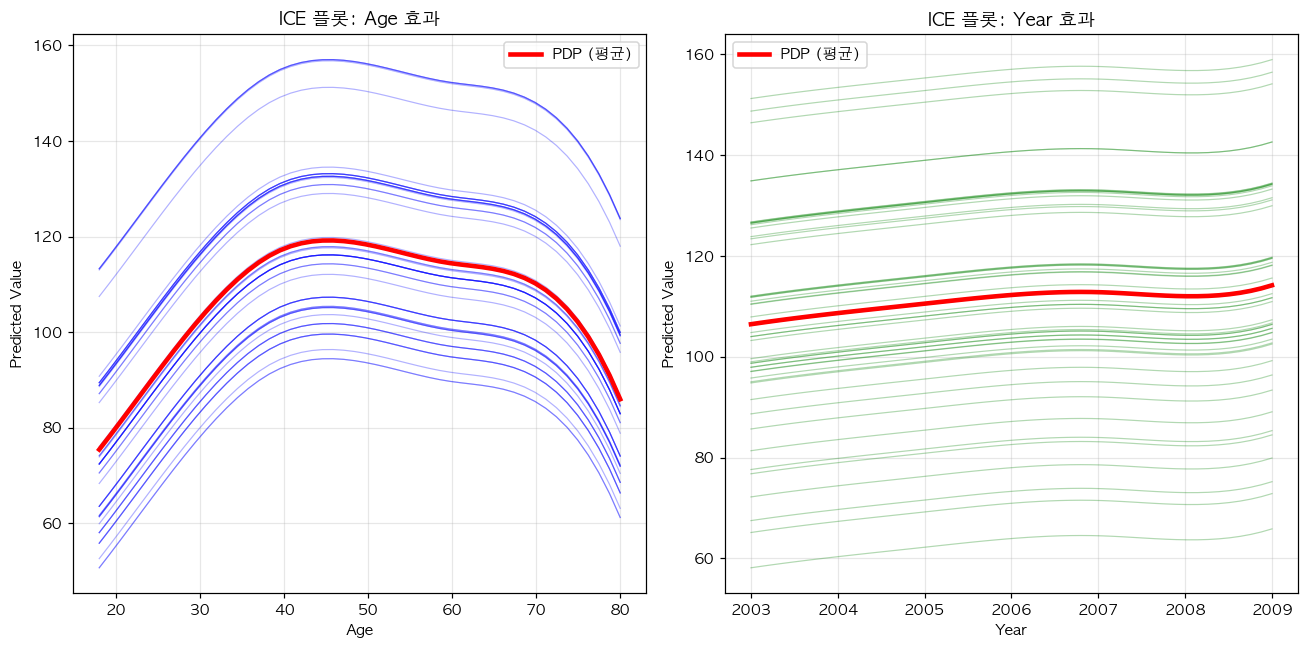

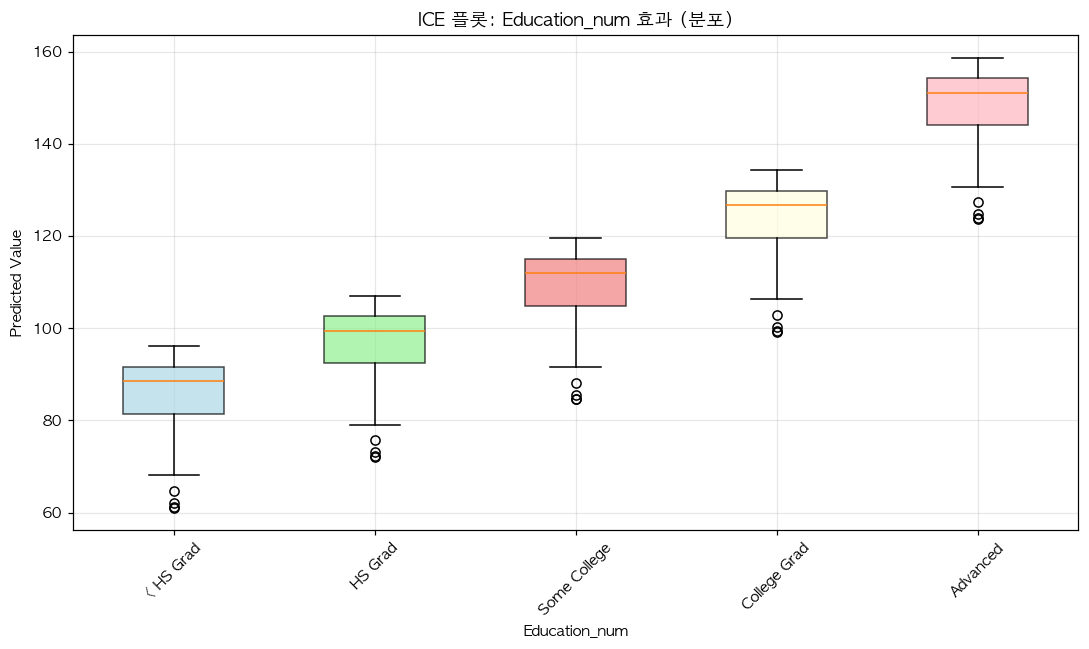

=== ICE 플롯 이질성 분석 ===


,Feature,Range_Effect,Mean_Std,Heterogeneity_%,Interpretation
0,Age,43.739,17.175,16.041,Medium
1,Year,7.715,20.879,18.801,Medium


In [76]:
# 연속형 : age, year
ice_results = plot_ice_curves(
    model=gam_pipeline,
    X_data=wage_clean[['age', 'year', 'education_num']],
    feature_names=['age', 'year'],
    n_samples=50,
    figsize=(12, 6)
)

# 범주형 : education
education_labels = ['< HS Grad', 'HS Grad', 'Some College', 'College Grad', 'Advanced']
education_ice_data = plot_categorical_ice(
    model=gam_pipeline,
    X_data=wage_clean[['age', 'year', 'education_num']],
    categorical_feature='education_num',
    feature_labels=education_labels,
    n_samples=50,
    figsize=(10, 6)
)

# 이질성 분석
heterogeneity_df = analyze_ice_heterogeneity(ice_results)

print("=== ICE 플롯 이질성 분석 ===")
display(heterogeneity_df.round(3))